# **Version 1**
### **Target**: <br/>
Get the CNN digit recognition pipeline ready, and use kernels in multiples of 10 [10,20,30] for obtaining a basic model architecture with fewer parameters.

### **Results**: <br/>
*	Parameters : **28,090**
*	Best Train Accuracy: 99.48% (Epoch 14)
*	Best Test Accuracy: **98.99%** (Epoch 14)

### **Analysis:** <br/>
*	Model performs well, but takes a while to reach 99% training accuracy (about 9 epochs), which will be addressed using Batch Normalization.
*	There is a gap in the train and test accuracy, indicating a problem of overfitting (can be made more robust using Dropout).
*	The number of kernels at each step can still be reduced to obtain a model having less than 10,000 total parameters (currently there are 2 layers with 5.4k parameters each, and 1 layer with 8k parameters).
*	The convolution layer at the end is for reducing the 5x5 feature maps to 1x1 values as the output of the model, but it is using a large sized kernel to do so. We can replace that with a Global Average Pooling layer in next version and hence, reduce parameters.

## **[1] Importing required libraries and packages**

In [1]:
# Importing the necessary packages
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets   as torch_datasets
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torch.utils.data   import Dataset
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

## **[2] Loading MNIST Dataset from torchivision datasets**

In [2]:
'''
    Transformation to be applied to the images before giving as input to model
    transforms.Compose() applies the transforms one after the other
    transforms.ToTensor() converts an np.array or PIL image into a pytorch tensor AND also compresses [0,255] 
    pixel range PIL Image (or uint8 array) into [0.,1.] float. In the other cases, tensors are returned WITHOUT scaling.
    (0.1307,), (0.3081,) is the mean and standard deviation for MNIST data
'''

# Applying Random affine transformations to the training data
transformations_train = transforms.Compose([transforms.ToTensor()
                                           ,transforms.Normalize((0.1307,), (0.3081,))
                                           ])

# The test data must not be randomly rotated, translated, etc. while validation, hence a different transform Compose
transformations_test = transforms.Compose([transforms.ToTensor()
                                    , transforms.Normalize((0.1307,), (0.3081,))])

# Loading a training set of X images and Test set of Y images (: split)
train_set = torch_datasets.MNIST('../mnist_data', train=True,
                                 download=True, transform=transformations_train)

test_set  = torch_datasets.MNIST('../mnist_data', train=False,
                                 download=True, transform=transformations_test)


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw
Processing...
Done!


## **[3] Making dataloader and getting number of classes**

In [3]:
batch_size_train = 128   # Set Batch size for the number of samples tu be taken at a time
batch_size_test  = 1024  # Larger batch size for eval set, for faster processing
SEED = 1                 # Set Randomization seed for Reproducible results

torch.manual_seed(SEED)                 
use_cuda = torch.cuda.is_available()    # Checks if Cuda is available, and returns True if yes

if use_cuda:
    torch.cuda.manual_seed(SEED)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Creating train and test sample loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size_train, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(test_set , batch_size = batch_size_test , shuffle=True, **kwargs)

'''
    The following 7 lines are to assert whether both training and test sets have the same number/type of 
    classes (with the same labelling) for classification, and assign the number to a variable 
    'num_classes' which will be equal to the number of kernel that will be used later in the 
    final convolution layer.
 '''
classes_in_train = train_set.targets.unique().numpy()
classes_in_test  = test_set.targets.unique().numpy()
assert np.isin(classes_in_test,classes_in_train).all()

num_classes = len(train_set.targets.unique().numpy())
print(f'Number of classes in MNIST: {num_classes}')
print(f'Number of images for training  : {len(train_set)}')
print(f'Number of images for validation: {len(test_set)}')

Number of classes in MNIST: 10
Number of images for training  : 60000
Number of images for validation: 10000


## **[4] CNN Model**

In [4]:
class Net(nn.Module):
    '''
        nn.Module is the base class for all Neural Network Modules, the Net() class is inheriting the base class nn.Module
        A Module contains the state of the layers in a Neural network and methods for feedforward and training the model
    '''
    def __init__(self):
        super(Net, self).__init__() 
        # Conv Block 1                                         #     INPUT    |    OUTPUT     | Receptive Field
        self.conv1 = nn.Conv2d( 1, 10, 3,padding=1,bias=False) # In: 28x28x1  | Out: 28x28x10 |      RF:3
        self.conv2 = nn.Conv2d(10, 20, 3,padding=1,bias=False) # In: 28x28x10 | Out: 28x28x20 |      RF:5
        self.conv3 = nn.Conv2d(20, 30, 3,bias=False)           # In: 28x28x20 | Out: 26x26x30 |      RF:7
                                                               #              |               |
        # Transition 1                                         #              |               |
        self.pool1 = nn.MaxPool2d(2, 2)                        # In: 26x26x30 | Out: 13x13x30 |      RF:8
        self.conv4 = nn.Conv2d(30, 10, 1,bias=False)           # In: 13x13x30 | Out: 13x13x30 |      RF:12
                                                               #              |               |
        # Conv Block 2                                         #              |               |
        self.conv5 = nn.Conv2d(10, 20, 3,bias=False)           # In: 13x13x30 | Out: 11x11x30 |      RF:16
        self.conv6 = nn.Conv2d(20, 30, 3,bias=False)           # In: 11x11x30 | Out:  9x9x30  |      RF:20
        self.conv7 = nn.Conv2d(30, 30, 3,bias=False)           # In: 9x9x30   | Out:  7x7x30  |      RF:24
        self.conv8 = nn.Conv2d(30, num_classes, 3,bias=False)  # In: 7x7x30   | Out:  5x5x10  |      RF:28
                                                               #              |               |
        # Output layer                                         #              |               |
        self.conv9 = nn.Conv2d(num_classes, num_classes, 5,bias=False)  
                                                               # In:  5x5x10  | Out:  1x1x10  |      RF:36
        

    def forward(self, x):
        '''
            Method for passing the input image through the network to get the output
            x here is a tensor at each stage, with the dimensions [N, C, H, W]:- 
            {N = No. of Samples, C = No. of channels, H = Height of Image, W = Width of Image}
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))

        x = self.conv9(x)
        x = x.view(-1, 10)               # Reshaping the tensor to a tensor with 10 columns and appropriate numbe of rows
        return F.log_softmax(x,dim=1)    # Computing Softmax of the obtained output

## **[5] Model Summary and Parameters**

In [5]:
device = torch.device("cuda" if use_cuda else "cpu") # Selects whether to run the model on GPU or CPU
model = Net().to(device)                # Loads the model weights on the gpu or cpu
summary(model, input_size=(1, 28, 28))  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
            Conv2d-2           [-1, 20, 28, 28]           1,800
            Conv2d-3           [-1, 30, 26, 26]           5,400
         MaxPool2d-4           [-1, 30, 13, 13]               0
            Conv2d-5           [-1, 10, 13, 13]             300
            Conv2d-6           [-1, 20, 11, 11]           1,800
            Conv2d-7             [-1, 30, 9, 9]           5,400
            Conv2d-8             [-1, 30, 7, 7]           8,100
            Conv2d-9             [-1, 10, 5, 5]           2,700
           Conv2d-10             [-1, 10, 1, 1]           2,500
Total params: 28,090
Trainable params: 28,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.11
Estimated Tot

## **[6] Train and Test functions**

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tq.tqdm(train_loader,leave=False)
    correct,processed = 0,0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. 
        # It’s important to call optimizer.zero_grad() before loss.backward(), otherwise gradients will be accumulated from multiple passes.
        y_pred = model(data)   # The feed forward pass for generating output from data
        loss = F.nll_loss(y_pred, target)   # Calculates the negative log likelihood loss for the given sets of output to predicted targets
        loss.backward()         # Calculates the d(loss)/dx for each parameter x, which are accumulated into x.grad
        optimizer.step()        # optimizer.step() multiples the learing rate with the x.grad and updates each model parameter
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100*(correct/processed)
        string_name = 'Epoch={} | Batch={} | Loss={:.6f} | Acc={:.2f}'.format(epoch,batch_idx,loss.item(),acc)
        pbar.set_description(desc=string_name) # Updates the description at every timestep while showing the progress bar
    
    # ---- Obtaining Training Accuracy for EPOCH -------
    model.eval() 
    total_train_loss = 0
    correct_train    = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    with torch.no_grad():
        for data, target in train_loader:
            data, target   = data.to(device), target.to(device)
            output         = model(data)
            total_train_loss += F.nll_loss(output, target, reduction='sum').item()   # sums up the loss for all samples in a batch
            pred           = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_train += pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target
    
    train_loss     = total_train_loss/len(train_loader.dataset)
    train_accuracy = 100. * (correct_train / len(train_loader.dataset))
    print('\nEpoch:{} Learning Rate:{}\nTrain Set: Mean loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)'.format(epoch,
        optimizer.param_groups[0]['lr'], train_loss, correct_train, len(train_loader.dataset),train_accuracy))
    return train_loss,train_accuracy

def test(model, device, test_loader):
    model.eval()
    total_test_loss = 0
    correct_test    = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            total_test_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred         = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_test+= pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    test_loss = total_test_loss/len(test_loader.dataset)
    test_accuracy = 100. * (correct_test / len(test_loader.dataset))
    print('Test Set : Mean loss: {:.4f}, Test Accuracy : {}/{} ({:.2f}%)\n'.format(
        test_loss, correct_test, len(test_loader.dataset),test_accuracy))
    return test_loss,test_accuracy

## **[7] Training the model**

In [8]:
model = Net().to(device)  # Copies the models weight tensors to GPU (if available)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  
epochs = 15
# Empty lists for storing training/test loss and accuracy values
train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

for epoch in range(0, epochs):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc   = test(model, device, test_loader)
    
    # if (test_acc >= 99.40):# Save the model if test_acc >= 99.4%
    #     model_path = '../mnist_data/trained_models/S1_model_epoch_'+str(epoch))
    #     torch.save(model.state_dict(), model_path)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 0.2693, Train Accuracy: 54895/60000 (91.49%)
Test Set : Mean loss: 0.2561, Test Accuracy : 9190/10000 (91.90%)




Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 0.1105, Train Accuracy: 57924/60000 (96.54%)
Test Set : Mean loss: 0.1049, Test Accuracy : 9678/10000 (96.78%)




Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.0727, Train Accuracy: 58652/60000 (97.75%)
Test Set : Mean loss: 0.0677, Test Accuracy : 9803/10000 (98.03%)




Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.0648, Train Accuracy: 58830/60000 (98.05%)
Test Set : Mean loss: 0.0708, Test Accuracy : 9786/10000 (97.86%)




Epoch:4 Learning Rate:0.01
Train Set: Mean loss: 0.0609, Train Accuracy: 58864/60000 (98.11%)
Test Set : Mean loss: 0.0721, Test Accuracy : 9775/10000 (97.75%)




Epoch:5 Learning Rate:0.01
Train Set: Mean loss: 0.0407, Train Accuracy: 59251/60000 (98.75%)
Test Set : Mean loss: 0.0458, Test Accuracy : 9863/10000 (98.63%)




Epoch:6 Learning Rate:0.01
Train Set: Mean loss: 0.0340, Train Accuracy: 59392/60000 (98.99%)
Test Set : Mean loss: 0.0440, Test Accuracy : 9857/10000 (98.57%)




Epoch:7 Learning Rate:0.01
Train Set: Mean loss: 0.0346, Train Accuracy: 59363/60000 (98.94%)
Test Set : Mean loss: 0.0429, Test Accuracy : 9866/10000 (98.66%)




Epoch:8 Learning Rate:0.01
Train Set: Mean loss: 0.0338, Train Accuracy: 59349/60000 (98.91%)
Test Set : Mean loss: 0.0432, Test Accuracy : 9864/10000 (98.64%)




Epoch:9 Learning Rate:0.01
Train Set: Mean loss: 0.0251, Train Accuracy: 59528/60000 (99.21%)
Test Set : Mean loss: 0.0381, Test Accuracy : 9889/10000 (98.89%)




Epoch:10 Learning Rate:0.01
Train Set: Mean loss: 0.0277, Train Accuracy: 59502/60000 (99.17%)
Test Set : Mean loss: 0.0413, Test Accuracy : 9874/10000 (98.74%)




Epoch:11 Learning Rate:0.01
Train Set: Mean loss: 0.0241, Train Accuracy: 59550/60000 (99.25%)
Test Set : Mean loss: 0.0395, Test Accuracy : 9880/10000 (98.80%)




Epoch:12 Learning Rate:0.01
Train Set: Mean loss: 0.0305, Train Accuracy: 59445/60000 (99.08%)
Test Set : Mean loss: 0.0455, Test Accuracy : 9861/10000 (98.61%)




Epoch:13 Learning Rate:0.01
Train Set: Mean loss: 0.0219, Train Accuracy: 59585/60000 (99.31%)
Test Set : Mean loss: 0.0410, Test Accuracy : 9872/10000 (98.72%)




Epoch:14 Learning Rate:0.01
Train Set: Mean loss: 0.0165, Train Accuracy: 59690/60000 (99.48%)
Test Set : Mean loss: 0.0359, Test Accuracy : 9899/10000 (98.99%)



## **[8] Loss and Accuracy Plots**

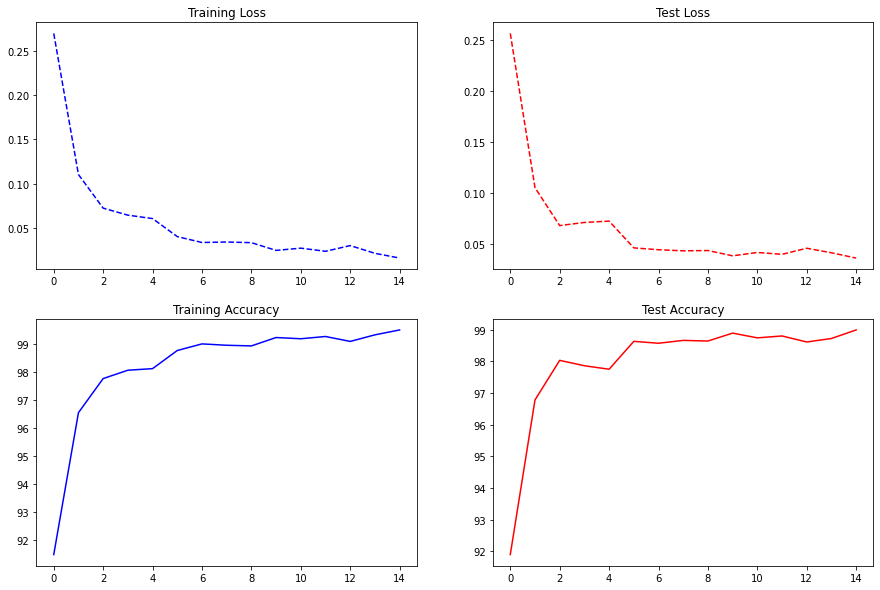

In [9]:
x_ticks = np.arange(0,epochs)
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(x_ticks,train_loss_vals, 'b--')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(x_ticks,train_acc_vals, 'b')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(x_ticks,test_loss_vals, 'r--')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(x_ticks,test_acc_vals, 'r')
axs[1, 1].set_title("Test Accuracy")
plt.savefig('../mnist_data/S1_mnist_plot.png')

## **[9] Results**

In [10]:
# num_row     = 4
# num_col     = 5
# num_images  = num_row*num_col

# random_batch  = np.random.randint(0, int(len(test_set)/batch_size_test))  # Select a random Batch
# random_images = np.random.randint(0, batch_size_test, size = num_images)  # Select a random sample of images in the batch

# model.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if batch_idx == random_batch:
#             images,labels = data[random_images].to(device), target[random_images].to(device)
#             output       = model(images)
#             pred         = output.argmax(dim=1, keepdim=True)
#             pred         = pred.view_as(labels)
#             break
# images,labels,pred  = images.cpu(),labels.cpu(),pred.cpu()

# # Plot the digit images with label and predictions
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.8*num_col,2.5*num_row))
# for i in range(num_images):
#     ax = axes[i//num_col, i%num_col]
#     ax.imshow(images[i][0], cmap='gray')
#     ax.set_title('Label: {}\nPrediction: {}'.format(labels[i],pred[i]))

# plt.tight_layout()
# plt.show()
# plt.savefig('../mnist_data/S1_prediction_vs_groundTruth.png')